In [164]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [165]:
import os
columns=["symboling","normalized-losses","make","fuel-type","aspiration","num-of-doors","body-style","drive-wheels",
         "engine-location","wheel-base","length","width","height","curb-weight","engine-type","num-of-cylinders",
         "engine-size","fuel-system","bore","stroke","compression-ratio","horsepower","peak-rpm","city-mpg","highway-mpg","price"]

In [166]:
print(columns)

['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']


In [167]:
#Read data from downloaded data file from https://archive.ics.uci.edu/ml/datasets.php
df = pd.read_csv("C:/Users/nitya/Documents/Ineuron/Assign1_tf_keras/imports-85.data")

In [168]:
df.head()

,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.60,...,130,mpfi,3.47,2.68,9.00,111,5000,21,27,13495
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
3,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
4,2,?,audi,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250


In [169]:
df.columns=columns

In [170]:
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
3,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
4,2,?,audi,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250


In [171]:
import seaborn as sns

Data Sanity Check
Find columns that need cleansing
List the count of non-numeric values in numric columns.

In [172]:
cols2numeric = ['symboling','normalized-losses','wheel-base','length', 'width','height','curb-weight','engine-size','bore','stroke','compression-ratio','horsepower','peak-rpm','city-mpg','highway-mpg','price']

print("***** Count of Non Numeric Elements - Columnwise ******")
for col in cols2numeric:
    if(pd.to_numeric(df[col],errors='coerce').isnull().sum() > 0):
        print(col + ": " + str(pd.to_numeric(df[col],errors='coerce').isnull().sum()))


***** Count of Non Numeric Elements - Columnwise ******
normalized-losses: 40
bore: 4
stroke: 4
horsepower: 2
peak-rpm: 2
price: 4


In [173]:
#List of columns that contain a "?" for missing data
colslist = list(df.columns)
for col in colslist:
    if('?' in df[col].value_counts()):
        print(col + " - " + str(df[col].value_counts()['?']))

normalized-losses - 40
num-of-doors - 2
bore - 4
stroke - 4
horsepower - 2
peak-rpm - 2
price - 4


Following columns will need to be sanitized, before they can be used for analysis.

1.normalized-losses
2.price
horsepower
bore
stroke
** 1. normalized-losses **

a. Convert "normalized-losses" column to numeric. In the process, insert NaNs where values cannot be converted to a number
b. Under each make, if there are enough number of records with valid loss values (>=50%), find their mean value and replace NaNs.
c. If more than 50% records under a make have NaNs for loss value, those records have to be discarded for analysis.

In [174]:
# Dataframe for Normalised-Losses related analysis
carsnl=df
#Replace non-numeric characters in normalized-losses column with NaN.
carsnl['normalized-losses'] = pd.to_numeric(carsnl['normalized-losses'],errors='coerce')

#Find makes having normalized-losses as NaNs and their number of occurrances 
carsnan=carsnl[carsnl['normalized-losses'].isnull()].groupby(by='make', as_index=False).size().reset_index()
carsnan.drop('index',axis=1,inplace=True)
carsnan.columns=['make','nanscount']
#Find makes with count of all records under each make
carsgp = carsnl.groupby(by='make',as_index=False).size().reset_index()
carsgp.drop('index',axis=1,inplace=True)
carsgp.columns=['make','makecount']
carsgpnan=carsgp.merge(carsnan,on="make", how="left", suffixes=['', '_right'])


#Find makes having more than 50% records with valid normalized-losses values
mean_nan_makes = carsgpnan[carsgpnan['nanscount']*100/carsgpnan['makecount'] <= 50].reset_index()
mean_nan_makes['nlimpute']=mean_nan_makes['make']
#Find mean loss figures for those makes
nlcars=carsnl.merge(mean_nan_makes, on="make", how="left", suffixes=['','_right'])
nlmean_by_make = nlcars.groupby(by='nlimpute')['normalized-losses'].mean().reset_index()

carsr=carsnl.merge(nlmean_by_make, how="left", left_on="make", right_on="nlimpute", suffixes=['', '_right'])
carsr['normalized-losses'] = np.where(carsr['normalized-losses'].isnull(), carsr['normalized-losses_right'], carsr['normalized-losses'])          
#carsnl=False

cars = carsr.loc[carsr['normalized-losses'].isnull()==False].copy()

print("Column normalized-losses has " + str(cars['normalized-losses'].count()) + " values after sanitizing")


Column normalized-losses has 189 values after sanitizing


In [175]:
cars.shape

(189, 28)

In [176]:
cars['price'] = pd.to_numeric(cars['price'],errors='coerce')
mean_price_by_make = cars.groupby(by=['make'])['price'].mean()
mean_price_by_make = mean_price_by_make.reset_index()
 
# Merge mean_price_by_make (Rigt) with cars dataframe (Left)

cars = cars.merge(mean_price_by_make,on='make', suffixes=['', '_right'])
cars['price'] = np.where(cars['price'].isnull(), cars['price_right'], cars['price'])
#cars[['make','price' ]]

In [177]:
cars.tail()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,nlimpute,normalized-losses_right,price_right
184,-1,95.0,volvo,gas,std,four,sedan,rwd,front,109.1,...,3.15,9.5,114,5400,23,28,16845.0,NaN,NaN,18063.181818
185,-1,95.0,volvo,gas,turbo,four,sedan,rwd,front,109.1,...,3.15,8.7,160,5300,19,25,19045.0,NaN,NaN,18063.181818
186,-1,95.0,volvo,gas,std,four,sedan,rwd,front,109.1,...,2.87,8.8,134,5500,18,23,21485.0,NaN,NaN,18063.181818
187,-1,95.0,volvo,diesel,turbo,four,sedan,rwd,front,109.1,...,3.40,23.0,106,4800,26,27,22470.0,NaN,NaN,18063.181818
188,-1,95.0,volvo,gas,turbo,four,sedan,rwd,front,109.1,...,3.15,9.5,114,5400,19,25,22625.0,NaN,NaN,18063.181818


**3. horsepower **
Convert to numeric

In [179]:
cars['horsepower'] = pd.to_numeric(cars['horsepower'], errors="coerce")

In [183]:
del cars['normalized-losses_right']
del cars['price_right']

KeyError: 'normalized-losses_right'

In [189]:
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,body-style,drive-wheels,engine-location,wheel-base,length,...,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,nlimpute,num_doors
0,2,164.0,audi,gas,std,sedan,fwd,front,99.8,176.6,...,3.19,3.40,10.0,102,5500,24,30,13950.0,audi,4
1,2,164.0,audi,gas,std,sedan,4wd,front,99.4,176.6,...,3.19,3.40,8.0,115,5500,18,22,17450.0,audi,4
2,2,161.0,audi,gas,std,sedan,fwd,front,99.8,177.3,...,3.19,3.40,8.5,110,5500,19,25,15250.0,audi,2
3,1,158.0,audi,gas,std,sedan,fwd,front,105.8,192.7,...,3.19,3.40,8.5,110,5500,19,25,17710.0,audi,4
4,1,161.0,audi,gas,std,wagon,fwd,front,105.8,192.7,...,3.19,3.40,8.5,110,5500,19,25,18920.0,audi,4


In [185]:
cars = cars[cars['num-of-doors'] != '?']

In [186]:
def calc_num_doors (doorstr):
    if(doorstr == 'two'):
       return 2 
    if (doorstr =='four'):
       return 4
    return 0
       
cars['num_doors'] = cars['num-of-doors'].apply(lambda x: calc_num_doors (x))

In [188]:
cars.drop('num-of-doors',axis=1,inplace=True)

In [190]:
def calc_num_cylinders(cylstr):
    cyls = {'two':2,'three':3,'four':4,'five':5,'six':6,'eight':8,'twelve':12}
    if(cylstr in cyls.keys()):
        return cyls[cylstr]
    return 0

cars['num_cylinders'] = cars['num-of-cylinders'].apply(lambda x: calc_num_cylinders(x))

In [192]:
cars.drop('num-of-cylinders',axis=1,inplace=True)

KeyError: "['num-of-cylinders'] not found in axis"

In [193]:
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,body-style,drive-wheels,engine-location,wheel-base,length,...,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,nlimpute,num_doors,num_cylinders
0,2,164.0,audi,gas,std,sedan,fwd,front,99.8,176.6,...,3.40,10.0,102,5500,24,30,13950.0,audi,4,4
1,2,164.0,audi,gas,std,sedan,4wd,front,99.4,176.6,...,3.40,8.0,115,5500,18,22,17450.0,audi,4,5
2,2,161.0,audi,gas,std,sedan,fwd,front,99.8,177.3,...,3.40,8.5,110,5500,19,25,15250.0,audi,2,5
3,1,158.0,audi,gas,std,sedan,fwd,front,105.8,192.7,...,3.40,8.5,110,5500,19,25,17710.0,audi,4,5
4,1,161.0,audi,gas,std,wagon,fwd,front,105.8,192.7,...,3.40,8.5,110,5500,19,25,18920.0,audi,4,5


In [194]:
cars = cars[cars['bore'] != '?']
cars = cars[cars['stroke'] != '?']

In [195]:
colslist = list(cars.columns)
for col in colslist:
    if('?' in cars[col].value_counts()):
        print(col + " - " + str(autodata[col].value_counts()['?']))

In [196]:
cars.to_csv('./cardata_cleaned.csv')

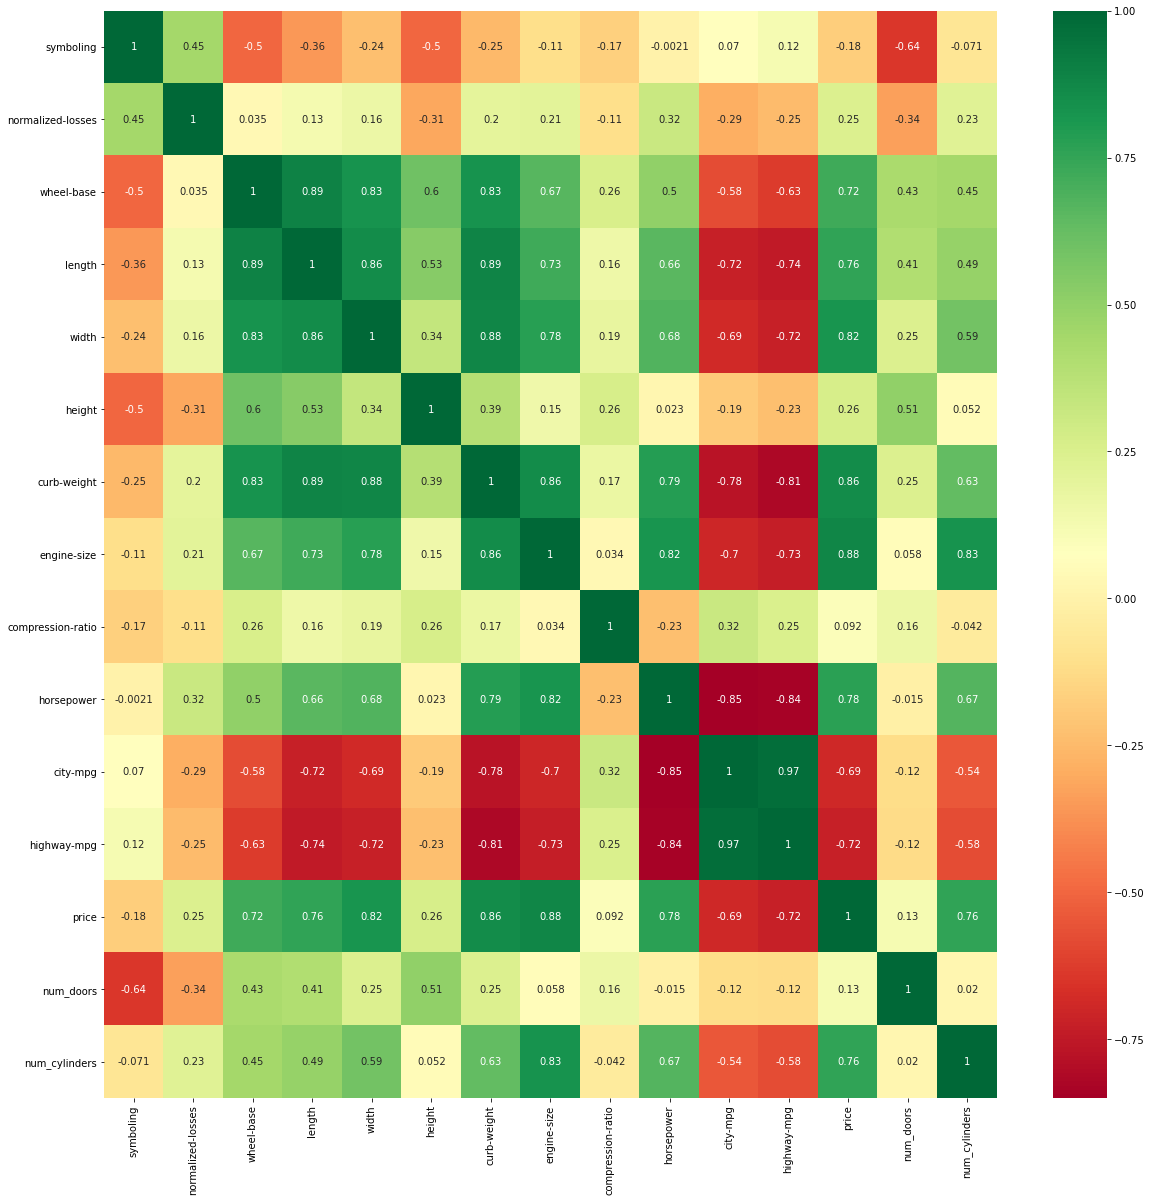

In [197]:
#get correlations of each features in dataset
corrmat = cars.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(cars[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [39]:
corrmat.index

Index(['symboling', 'wheel-base', 'length', 'width', 'height', 'curb-weight',
       'engine-size', 'compression-ratio', 'city-mpg', 'highway-mpg'],
      dtype='object')

In [199]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [200]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [202]:
cars.drop(df[to_drop], axis=1,inplace=True)

In [203]:
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,body-style,drive-wheels,engine-location,wheel-base,length,...,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,price,nlimpute,num_doors,num_cylinders
0,2,164.0,audi,gas,std,sedan,fwd,front,99.8,176.6,...,3.19,3.40,10.0,102,5500,24,13950.0,audi,4,4
1,2,164.0,audi,gas,std,sedan,4wd,front,99.4,176.6,...,3.19,3.40,8.0,115,5500,18,17450.0,audi,4,5
2,2,161.0,audi,gas,std,sedan,fwd,front,99.8,177.3,...,3.19,3.40,8.5,110,5500,19,15250.0,audi,2,5
3,1,158.0,audi,gas,std,sedan,fwd,front,105.8,192.7,...,3.19,3.40,8.5,110,5500,19,17710.0,audi,4,5
4,1,161.0,audi,gas,std,wagon,fwd,front,105.8,192.7,...,3.19,3.40,8.5,110,5500,19,18920.0,audi,4,5


In [207]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 0 to 188
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          183 non-null    int64  
 1   normalized-losses  183 non-null    float64
 2   make               183 non-null    object 
 3   fuel-type          183 non-null    object 
 4   aspiration         183 non-null    object 
 5   body-style         183 non-null    object 
 6   drive-wheels       183 non-null    object 
 7   engine-location    183 non-null    object 
 8   wheel-base         183 non-null    float64
 9   length             183 non-null    float64
 10  width              183 non-null    float64
 11  height             183 non-null    float64
 12  curb-weight        183 non-null    int64  
 13  engine-type        183 non-null    object 
 14  engine-size        183 non-null    int64  
 15  fuel-system        183 non-null    object 
 16  bore               183 non

In [205]:
cars['bore'] = pd.to_numeric(cars['bore'], errors="coerce")
cars['stroke'] = pd.to_numeric(cars['stroke'], errors="coerce")

In [208]:
cars.drop('nlimpute',axis=1,inplace=True)

In [209]:
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,body-style,drive-wheels,engine-location,wheel-base,length,...,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,price,num_doors,num_cylinders
0,2,164.0,audi,gas,std,sedan,fwd,front,99.8,176.6,...,mpfi,3.19,3.4,10.0,102,5500,24,13950.0,4,4
1,2,164.0,audi,gas,std,sedan,4wd,front,99.4,176.6,...,mpfi,3.19,3.4,8.0,115,5500,18,17450.0,4,5
2,2,161.0,audi,gas,std,sedan,fwd,front,99.8,177.3,...,mpfi,3.19,3.4,8.5,110,5500,19,15250.0,2,5
3,1,158.0,audi,gas,std,sedan,fwd,front,105.8,192.7,...,mpfi,3.19,3.4,8.5,110,5500,19,17710.0,4,5
4,1,161.0,audi,gas,std,wagon,fwd,front,105.8,192.7,...,mpfi,3.19,3.4,8.5,110,5500,19,18920.0,4,5


In [211]:
cat_features=[feature for feature in cars.columns if cars[feature].dtypes=='O']
cat_features

['make',
 'fuel-type',
 'aspiration',
 'body-style',
 'drive-wheels',
 'engine-location',
 'engine-type',
 'fuel-system',
 'peak-rpm']

In [212]:
for feature in cat_features:
    labels_ordered=cars.groupby([feature])['price'].mean().sort_values().index
    labels_ordered={k:i for i,k in enumerate(labels_ordered,0)}
    cars[feature]=cars[feature].map(labels_ordered)

In [213]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 0 to 188
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          183 non-null    int64  
 1   normalized-losses  183 non-null    float64
 2   make               183 non-null    int64  
 3   fuel-type          183 non-null    int64  
 4   aspiration         183 non-null    int64  
 5   body-style         183 non-null    int64  
 6   drive-wheels       183 non-null    int64  
 7   engine-location    183 non-null    int64  
 8   wheel-base         183 non-null    float64
 9   length             183 non-null    float64
 10  width              183 non-null    float64
 11  height             183 non-null    float64
 12  curb-weight        183 non-null    int64  
 13  engine-type        183 non-null    int64  
 14  engine-size        183 non-null    int64  
 15  fuel-system        183 non-null    int64  
 16  bore               183 non

In [215]:
X=cars.drop('price',axis=1)
y=cars.price

In [217]:
y.head()

0    13950.0
1    17450.0
2    15250.0
3    17710.0
4    18920.0
Name: price, dtype: float64

<AxesSubplot:xlabel='price'>

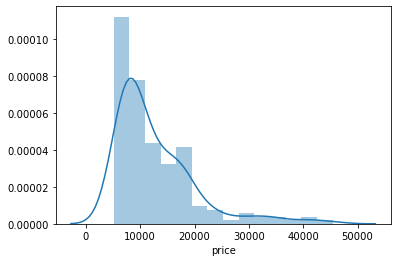

In [218]:
sns.distplot(y)

In [221]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [226]:
# Importing the Keras libraries and packages
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model

In [250]:
model5 = tf.keras.models.Sequential([
 tf.keras.layers.Dense(X_train.shape[1],activation=tf.nn.relu),
 tf.keras.layers.Flatten(),
 tf.keras.layers.Dense(512,activation=tf.nn.relu),
 tf.keras.layers.Dropout(0.2),
 tf.keras.layers.Dense(1,activation=tf.nn.relu)
])


In [253]:
optimiser = tf.keras.optimizers.Adam()
model5.compile (optimizer= optimiser, loss='mean_absolute_error', metrics = ['mean_absolute_error'])

In [240]:
model5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
flatten_1 (Flatten)          (None, 24)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               12800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 13,913
Trainable params: 13,913
Non-trainable params: 0
_________________________________________________________________


In [244]:
model5.fit(X_train,y_train,batch_size=12,epochs=1000)

Epoch 1/1000
11/11 [==============================] - 0s 1ms/step - loss: 2863.5813 - mean_absolute_error: 2863.5813
Epoch 2/1000
11/11 [==============================] - 0s 1ms/step - loss: 2851.6133 - mean_absolute_error: 2851.6133
Epoch 3/1000
11/11 [==============================] - 0s 1ms/step - loss: 2832.5962 - mean_absolute_error: 2832.5962
Epoch 4/1000
11/11 [==============================] - 0s 1ms/step - loss: 2876.4443 - mean_absolute_error: 2876.4443
Epoch 5/1000
11/11 [==============================] - 0s 1ms/step - loss: 2846.5122 - mean_absolute_error: 2846.5122
Epoch 6/1000
11/11 [==============================] - 0s 1ms/step - loss: 2807.0762 - mean_absolute_error: 2807.0762
Epoch 7/1000
11/11 [==============================] - 0s 3ms/step - loss: 2806.6016 - mean_absolute_error: 2806.6016
Epoch 8/1000
11/11 [==============================] - 0s 2ms/step - loss: 2740.0859 - mean_absolute_error: 2740.0859
Epoch 9/1000
11/11 [==============================] - 0s 2ms/ste

Epoch 70/1000
11/11 [==============================] - 0s 1ms/step - loss: 2376.1482 - mean_absolute_error: 2376.1482
Epoch 71/1000
11/11 [==============================] - 0s 2ms/step - loss: 2271.1135 - mean_absolute_error: 2271.1135
Epoch 72/1000
11/11 [==============================] - 0s 2ms/step - loss: 2172.8572 - mean_absolute_error: 2172.8572
Epoch 73/1000
11/11 [==============================] - 0s 2ms/step - loss: 2236.4106 - mean_absolute_error: 2236.4106
Epoch 74/1000
11/11 [==============================] - 0s 2ms/step - loss: 2295.6978 - mean_absolute_error: 2295.6978
Epoch 75/1000
11/11 [==============================] - 0s 2ms/step - loss: 2185.9324 - mean_absolute_error: 2185.9324
Epoch 76/1000
11/11 [==============================] - 0s 2ms/step - loss: 2181.8589 - mean_absolute_error: 2181.8589
Epoch 77/1000
11/11 [==============================] - 0s 2ms/step - loss: 2211.4717 - mean_absolute_error: 2211.4717
Epoch 78/1000
11/11 [==============================] - 0

11/11 [==============================] - 0s 2ms/step - loss: 2030.8612 - mean_absolute_error: 2030.8612
Epoch 139/1000
11/11 [==============================] - 0s 1ms/step - loss: 2040.5188 - mean_absolute_error: 2040.5188
Epoch 140/1000
11/11 [==============================] - 0s 3ms/step - loss: 1993.0892 - mean_absolute_error: 1993.0892
Epoch 141/1000
11/11 [==============================] - 0s 2ms/step - loss: 2015.1753 - mean_absolute_error: 2015.1753
Epoch 142/1000
11/11 [==============================] - 0s 2ms/step - loss: 1991.8837 - mean_absolute_error: 1991.8837
Epoch 143/1000
11/11 [==============================] - 0s 3ms/step - loss: 1923.9727 - mean_absolute_error: 1923.9727
Epoch 144/1000
11/11 [==============================] - 0s 2ms/step - loss: 2007.4312 - mean_absolute_error: 2007.4312
Epoch 145/1000
11/11 [==============================] - 0s 3ms/step - loss: 1989.7029 - mean_absolute_error: 1989.7029
Epoch 146/1000
11/11 [==============================] - 0s 2ms/

11/11 [==============================] - 0s 2ms/step - loss: 1880.9524 - mean_absolute_error: 1880.9524
Epoch 207/1000
11/11 [==============================] - 0s 2ms/step - loss: 1917.0791 - mean_absolute_error: 1917.0791
Epoch 208/1000
11/11 [==============================] - 0s 1ms/step - loss: 1781.3683 - mean_absolute_error: 1781.3683
Epoch 209/1000
11/11 [==============================] - 0s 2ms/step - loss: 1812.8323 - mean_absolute_error: 1812.8323
Epoch 210/1000
11/11 [==============================] - 0s 2ms/step - loss: 1982.3347 - mean_absolute_error: 1982.3347
Epoch 211/1000
11/11 [==============================] - 0s 2ms/step - loss: 1849.2028 - mean_absolute_error: 1849.2028
Epoch 212/1000
11/11 [==============================] - 0s 2ms/step - loss: 1858.1086 - mean_absolute_error: 1858.1086
Epoch 213/1000
11/11 [==============================] - 0s 2ms/step - loss: 1856.8597 - mean_absolute_error: 1856.8597
Epoch 214/1000
11/11 [==============================] - 0s 2ms/

Epoch 275/1000
11/11 [==============================] - 0s 2ms/step - loss: 1622.9862 - mean_absolute_error: 1622.9862
Epoch 276/1000
11/11 [==============================] - 0s 1ms/step - loss: 1692.6870 - mean_absolute_error: 1692.6870
Epoch 277/1000
11/11 [==============================] - 0s 2ms/step - loss: 1754.3153 - mean_absolute_error: 1754.3153
Epoch 278/1000
11/11 [==============================] - ETA: 0s - loss: 1860.6670 - mean_absolute_error: 1860.667 - 0s 2ms/step - loss: 1702.5801 - mean_absolute_error: 1702.5801
Epoch 279/1000
11/11 [==============================] - 0s 2ms/step - loss: 1669.7900 - mean_absolute_error: 1669.7900
Epoch 280/1000
11/11 [==============================] - 0s 2ms/step - loss: 1706.4872 - mean_absolute_error: 1706.4872
Epoch 281/1000
11/11 [==============================] - 0s 2ms/step - loss: 1643.8363 - mean_absolute_error: 1643.8363
Epoch 282/1000
11/11 [==============================] - 0s 2ms/step - loss: 1677.4120 - mean_absolute_error

11/11 [==============================] - 0s 2ms/step - loss: 1628.0630 - mean_absolute_error: 1628.0630
Epoch 344/1000
11/11 [==============================] - 0s 2ms/step - loss: 1612.4456 - mean_absolute_error: 1612.4456
Epoch 345/1000
11/11 [==============================] - 0s 2ms/step - loss: 1481.0292 - mean_absolute_error: 1481.0292
Epoch 346/1000
11/11 [==============================] - 0s 1ms/step - loss: 1571.1044 - mean_absolute_error: 1571.1044
Epoch 347/1000
11/11 [==============================] - 0s 2ms/step - loss: 1629.3037 - mean_absolute_error: 1629.3037
Epoch 348/1000
11/11 [==============================] - 0s 2ms/step - loss: 1596.4288 - mean_absolute_error: 1596.4288
Epoch 349/1000
11/11 [==============================] - 0s 2ms/step - loss: 1585.0281 - mean_absolute_error: 1585.0281
Epoch 350/1000
11/11 [==============================] - 0s 2ms/step - loss: 1658.4161 - mean_absolute_error: 1658.4161
Epoch 351/1000
11/11 [==============================] - 0s 2ms/

Epoch 412/1000
11/11 [==============================] - 0s 2ms/step - loss: 1607.7090 - mean_absolute_error: 1607.7090
Epoch 413/1000
11/11 [==============================] - 0s 2ms/step - loss: 1575.4915 - mean_absolute_error: 1575.4915
Epoch 414/1000
11/11 [==============================] - 0s 2ms/step - loss: 1578.9423 - mean_absolute_error: 1578.9423
Epoch 415/1000
11/11 [==============================] - 0s 2ms/step - loss: 1538.3481 - mean_absolute_error: 1538.3483
Epoch 416/1000
11/11 [==============================] - 0s 2ms/step - loss: 1569.1401 - mean_absolute_error: 1569.1401
Epoch 417/1000
11/11 [==============================] - 0s 2ms/step - loss: 1509.2041 - mean_absolute_error: 1509.2041
Epoch 418/1000
11/11 [==============================] - 0s 3ms/step - loss: 1476.4313 - mean_absolute_error: 1476.4313
Epoch 419/1000
11/11 [==============================] - 0s 3ms/step - loss: 1574.4904 - mean_absolute_error: 1574.4904
Epoch 420/1000
11/11 [==========================

11/11 [==============================] - 0s 2ms/step - loss: 1500.6855 - mean_absolute_error: 1500.6855
Epoch 481/1000
11/11 [==============================] - 0s 3ms/step - loss: 1556.2516 - mean_absolute_error: 1556.2516
Epoch 482/1000
11/11 [==============================] - 0s 2ms/step - loss: 1709.2858 - mean_absolute_error: 1709.2858
Epoch 483/1000
11/11 [==============================] - 0s 2ms/step - loss: 1610.0920 - mean_absolute_error: 1610.0920
Epoch 484/1000
11/11 [==============================] - 0s 3ms/step - loss: 1478.2811 - mean_absolute_error: 1478.2811
Epoch 485/1000
11/11 [==============================] - 0s 2ms/step - loss: 1521.3898 - mean_absolute_error: 1521.3898
Epoch 486/1000
11/11 [==============================] - 0s 2ms/step - loss: 1561.3752 - mean_absolute_error: 1561.3752
Epoch 487/1000
11/11 [==============================] - 0s 2ms/step - loss: 1545.7528 - mean_absolute_error: 1545.7528
Epoch 488/1000
11/11 [==============================] - 0s 1ms/

Epoch 549/1000
11/11 [==============================] - 0s 2ms/step - loss: 1506.9910 - mean_absolute_error: 1506.9910
Epoch 550/1000
11/11 [==============================] - 0s 2ms/step - loss: 1483.6200 - mean_absolute_error: 1483.6200
Epoch 551/1000
11/11 [==============================] - 0s 2ms/step - loss: 1519.5870 - mean_absolute_error: 1519.5870
Epoch 552/1000
11/11 [==============================] - 0s 2ms/step - loss: 1567.4764 - mean_absolute_error: 1567.4764
Epoch 553/1000
11/11 [==============================] - 0s 2ms/step - loss: 1533.3248 - mean_absolute_error: 1533.3248
Epoch 554/1000
11/11 [==============================] - ETA: 0s - loss: 1211.4609 - mean_absolute_error: 1211.460 - 0s 2ms/step - loss: 1535.5809 - mean_absolute_error: 1535.5809
Epoch 555/1000
11/11 [==============================] - 0s 2ms/step - loss: 1402.7408 - mean_absolute_error: 1402.7408
Epoch 556/1000
11/11 [==============================] - 0s 2ms/step - loss: 1482.4618 - mean_absolute_error

11/11 [==============================] - 0s 2ms/step - loss: 1564.5070 - mean_absolute_error: 1564.5070
Epoch 618/1000
11/11 [==============================] - 0s 2ms/step - loss: 1438.1135 - mean_absolute_error: 1438.1135
Epoch 619/1000
11/11 [==============================] - 0s 2ms/step - loss: 1506.6774 - mean_absolute_error: 1506.6774
Epoch 620/1000
11/11 [==============================] - 0s 2ms/step - loss: 1354.0790 - mean_absolute_error: 1354.0789
Epoch 621/1000
11/11 [==============================] - 0s 1ms/step - loss: 1445.1233 - mean_absolute_error: 1445.1233
Epoch 622/1000
11/11 [==============================] - 0s 2ms/step - loss: 1447.1230 - mean_absolute_error: 1447.1230
Epoch 623/1000
11/11 [==============================] - 0s 2ms/step - loss: 1474.1360 - mean_absolute_error: 1474.1360
Epoch 624/1000
11/11 [==============================] - 0s 2ms/step - loss: 1319.8358 - mean_absolute_error: 1319.8358
Epoch 625/1000
11/11 [==============================] - 0s 2ms/

Epoch 686/1000
11/11 [==============================] - 0s 1ms/step - loss: 1579.5225 - mean_absolute_error: 1579.5225
Epoch 687/1000
11/11 [==============================] - 0s 1ms/step - loss: 1508.6848 - mean_absolute_error: 1508.6848
Epoch 688/1000
11/11 [==============================] - 0s 2ms/step - loss: 1538.5436 - mean_absolute_error: 1538.5436
Epoch 689/1000
11/11 [==============================] - 0s 2ms/step - loss: 1507.1654 - mean_absolute_error: 1507.1654
Epoch 690/1000
11/11 [==============================] - 0s 2ms/step - loss: 1413.1814 - mean_absolute_error: 1413.1814
Epoch 691/1000
11/11 [==============================] - 0s 2ms/step - loss: 1441.6222 - mean_absolute_error: 1441.6222
Epoch 692/1000
11/11 [==============================] - 0s 2ms/step - loss: 1497.8080 - mean_absolute_error: 1497.8080
Epoch 693/1000
11/11 [==============================] - 0s 2ms/step - loss: 1487.0840 - mean_absolute_error: 1487.0839
Epoch 694/1000
11/11 [==========================

11/11 [==============================] - 0s 2ms/step - loss: 1421.3540 - mean_absolute_error: 1421.3540
Epoch 755/1000
11/11 [==============================] - 0s 1ms/step - loss: 1514.6711 - mean_absolute_error: 1514.6711
Epoch 756/1000
11/11 [==============================] - 0s 1ms/step - loss: 1438.6521 - mean_absolute_error: 1438.6521
Epoch 757/1000
11/11 [==============================] - 0s 2ms/step - loss: 1537.8972 - mean_absolute_error: 1537.8972
Epoch 758/1000
11/11 [==============================] - 0s 2ms/step - loss: 1443.7751 - mean_absolute_error: 1443.7751
Epoch 759/1000
11/11 [==============================] - 0s 2ms/step - loss: 1412.7542 - mean_absolute_error: 1412.7542
Epoch 760/1000
11/11 [==============================] - ETA: 0s - loss: 1870.6532 - mean_absolute_error: 1870.653 - 0s 2ms/step - loss: 1410.2113 - mean_absolute_error: 1410.2113
Epoch 761/1000
11/11 [==============================] - 0s 2ms/step - loss: 1454.8093 - mean_absolute_error: 1454.8093
Epo

11/11 [==============================] - 0s 2ms/step - loss: 1575.8082 - mean_absolute_error: 1575.8082
Epoch 823/1000
11/11 [==============================] - 0s 2ms/step - loss: 1362.7799 - mean_absolute_error: 1362.7799
Epoch 824/1000
11/11 [==============================] - 0s 2ms/step - loss: 1373.3131 - mean_absolute_error: 1373.3131
Epoch 825/1000
11/11 [==============================] - 0s 2ms/step - loss: 1422.8577 - mean_absolute_error: 1422.8577
Epoch 826/1000
11/11 [==============================] - 0s 2ms/step - loss: 1484.4172 - mean_absolute_error: 1484.4172
Epoch 827/1000
11/11 [==============================] - 0s 2ms/step - loss: 1450.6002 - mean_absolute_error: 1450.6002
Epoch 828/1000
11/11 [==============================] - 0s 2ms/step - loss: 1368.2853 - mean_absolute_error: 1368.2853
Epoch 829/1000
11/11 [==============================] - 0s 2ms/step - loss: 1507.2083 - mean_absolute_error: 1507.2083
Epoch 830/1000
11/11 [==============================] - 0s 2ms/

Epoch 891/1000
11/11 [==============================] - 0s 2ms/step - loss: 1336.4244 - mean_absolute_error: 1336.4244
Epoch 892/1000
11/11 [==============================] - 0s 2ms/step - loss: 1441.5308 - mean_absolute_error: 1441.5308
Epoch 893/1000
11/11 [==============================] - 0s 2ms/step - loss: 1378.0186 - mean_absolute_error: 1378.0186
Epoch 894/1000
11/11 [==============================] - 0s 2ms/step - loss: 1420.5153 - mean_absolute_error: 1420.5153
Epoch 895/1000
11/11 [==============================] - 0s 2ms/step - loss: 1381.7509 - mean_absolute_error: 1381.7509
Epoch 896/1000
11/11 [==============================] - 0s 2ms/step - loss: 1404.3608 - mean_absolute_error: 1404.3607
Epoch 897/1000
11/11 [==============================] - 0s 2ms/step - loss: 1435.7323 - mean_absolute_error: 1435.7323
Epoch 898/1000
11/11 [==============================] - 0s 2ms/step - loss: 1421.0725 - mean_absolute_error: 1421.0725
Epoch 899/1000
11/11 [==========================

11/11 [==============================] - 0s 2ms/step - loss: 1437.4489 - mean_absolute_error: 1437.4489
Epoch 960/1000
11/11 [==============================] - 0s 1ms/step - loss: 1431.5007 - mean_absolute_error: 1431.5007
Epoch 961/1000
11/11 [==============================] - 0s 2ms/step - loss: 1436.7891 - mean_absolute_error: 1436.7891
Epoch 962/1000
11/11 [==============================] - 0s 2ms/step - loss: 1397.1389 - mean_absolute_error: 1397.1389
Epoch 963/1000
11/11 [==============================] - 0s 2ms/step - loss: 1504.6588 - mean_absolute_error: 1504.6588
Epoch 964/1000
11/11 [==============================] - 0s 2ms/step - loss: 1400.6572 - mean_absolute_error: 1400.6572
Epoch 965/1000
11/11 [==============================] - 0s 2ms/step - loss: 1380.2878 - mean_absolute_error: 1380.2878
Epoch 966/1000
11/11 [==============================] - 0s 2ms/step - loss: 1337.3507 - mean_absolute_error: 1337.3507
Epoch 967/1000
11/11 [==============================] - 0s 2ms/

In [254]:
model5.evaluate(X_test,y_test,steps=10)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 0s 998us/step - loss: 12538.6592 - mean_absolute_error: 12538.6592


[12538.6591796875, 12538.6591796875]

In [255]:
pwd

'C:\\Users\\nitya\\Documents\\Ineuron\\DL_Tensor_Flow'